In [ ]:
!unzip data.zip

In [7]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

# ---

# ## 2. Configuration and Paths
# 모델과 데이터 로딩에 필요한 주요 파라미터를 설정합니다.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 100
EPOCHS = 30 # EarlyStopping을 사용하므로 최대 Epoch 설정

# 데이터 경로 설정 (사용자 요청에 따라 형식 유지)
data_path = '/content/Dataset'
train_folder_path = os.path.join(data_path, 'train')
test_folder_path = os.path.join(data_path, 'test')


Class names found: ['cloth', 'n95', 'n95v', 'nfm', 'srg']


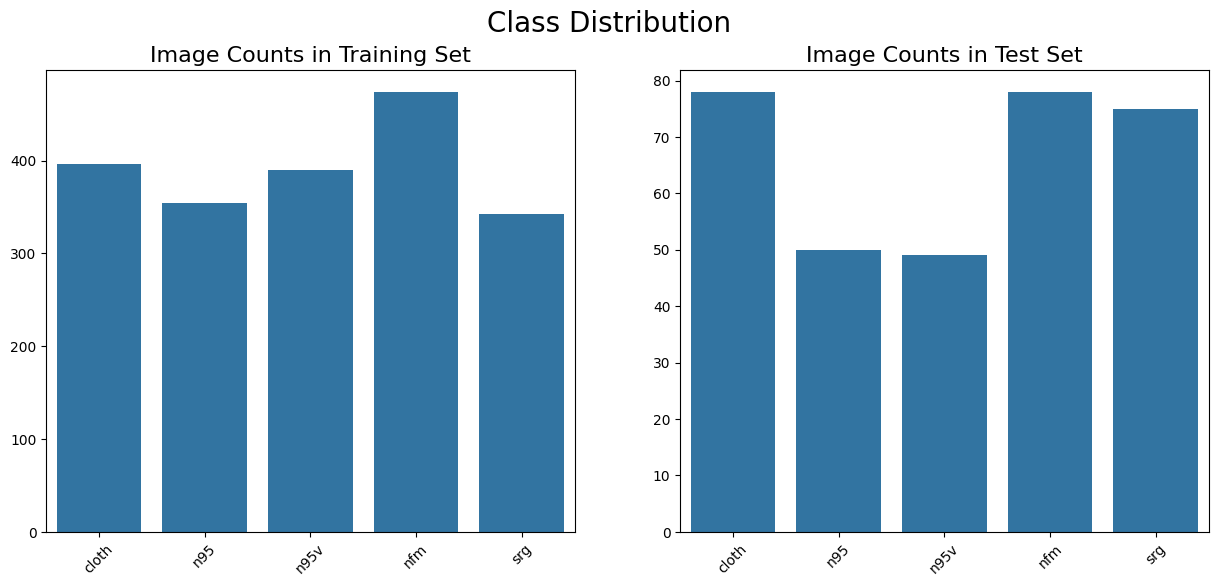

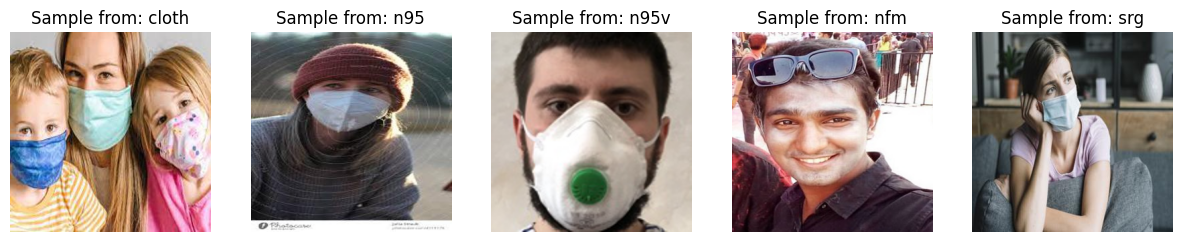

In [3]:
class_names = sorted([d for d in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, d))])
print(f"Class names found: {class_names}")

# 클래스별 데이터 수량 확인 및 시각화
train_counts = {cls: len(os.listdir(os.path.join(train_folder_path, cls))) for cls in class_names}
test_counts = {cls: len(os.listdir(os.path.join(test_folder_path, cls))) for cls in class_names}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1)
ax1.set_title('Image Counts in Training Set', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2)
ax2.set_title('Image Counts in Test Set', fontsize=16)
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Class Distribution', fontsize=20)
plt.show()

# 각 클래스별 샘플 이미지 확인
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_folder_path, class_name)
    random_image = random.choice(os.listdir(class_dir))
    img = plt.imread(os.path.join(class_dir, random_image))

    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img)
    plt.title(f'Sample from: {class_name}')
    plt.axis('off')
plt.show()

In [4]:
# ## 4. Data Augmentation & Generators
# ImageDataGenerator를 사용하여 데이터 증강 및 배치를 생성합니다.
if class_names:
    # 훈련 데이터용 ImageDataGenerator (증강 및 검증 데이터 분할 적용)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2 # 훈련 데이터의 20%를 검증용으로 사용
    )

    # 테스트 데이터용 ImageDataGenerator (증강 미적용)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 제너레이터 생성
    train_generator = train_datagen.flow_from_directory(
        train_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

Found 1567 images belonging to 5 classes.
Found 389 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [8]:
# ## 5. Model Building (Transfer Learning with MobileNetV2)
if class_names:
    # MobileNetV2 베이스 모델 로드
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model.trainable = False

    # 커스텀 분류기 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# ## 6. Model Training
if class_names:
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4301 - loss: 1.5084 - val_accuracy: 0.7147 - val_loss: 0.7367 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.6994 - loss: 0.7698 - val_accuracy: 0.7969 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.7428 - loss: 0.6718 - val_accuracy: 0.7892 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.7678 - loss: 0.5900 - val_accuracy: 0.8046 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step - accuracy: 0.7861 - loss: 0.5661 - val_accuracy: 0.7866 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 658ms/step - accuracy: 0.8011 - loss: 0.4976 - val_accuracy: 0.8380 - val_loss: 0.4566 - learning_rate: 0.0010
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.8207 - loss: 0.478

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7804 - loss: 0.5308

Test Accuracy: 82.12%


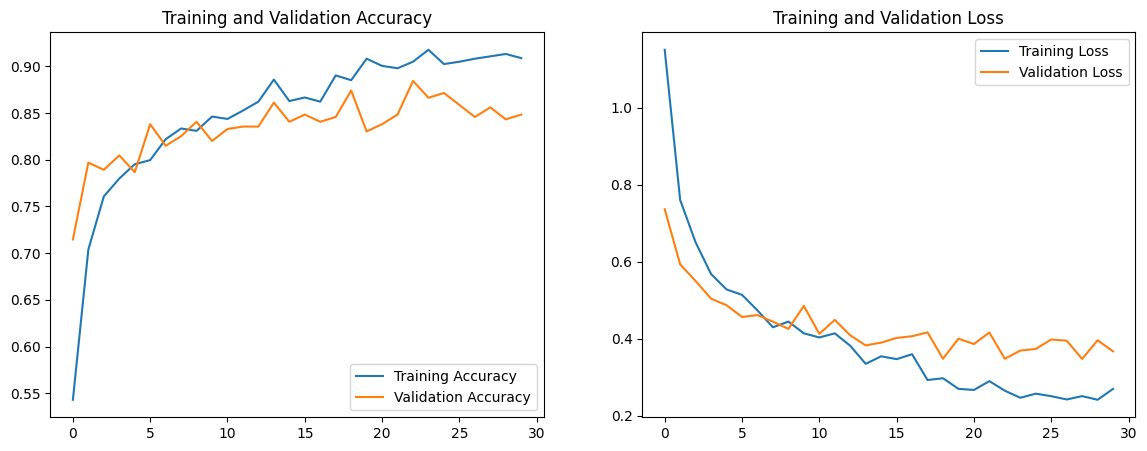

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 615ms/step


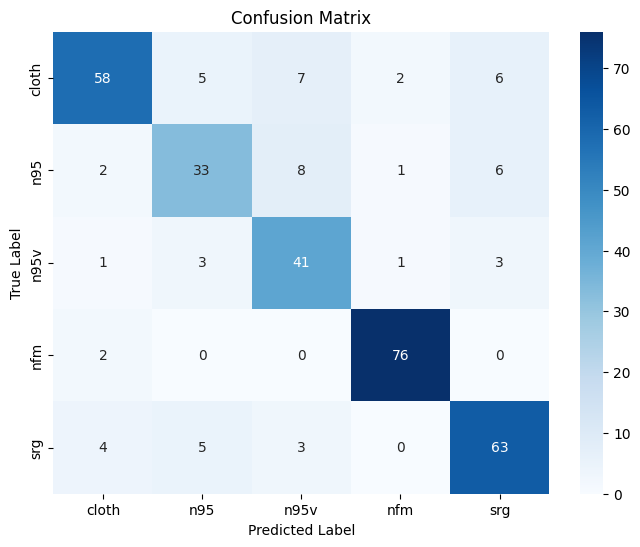


Classification Report
              precision    recall  f1-score   support

       cloth       0.87      0.74      0.80        78
         n95       0.72      0.66      0.69        50
        n95v       0.69      0.84      0.76        49
         nfm       0.95      0.97      0.96        78
         srg       0.81      0.84      0.82        75

    accuracy                           0.82       330
   macro avg       0.81      0.81      0.81       330
weighted avg       0.82      0.82      0.82       330


Total misclassified images: 59



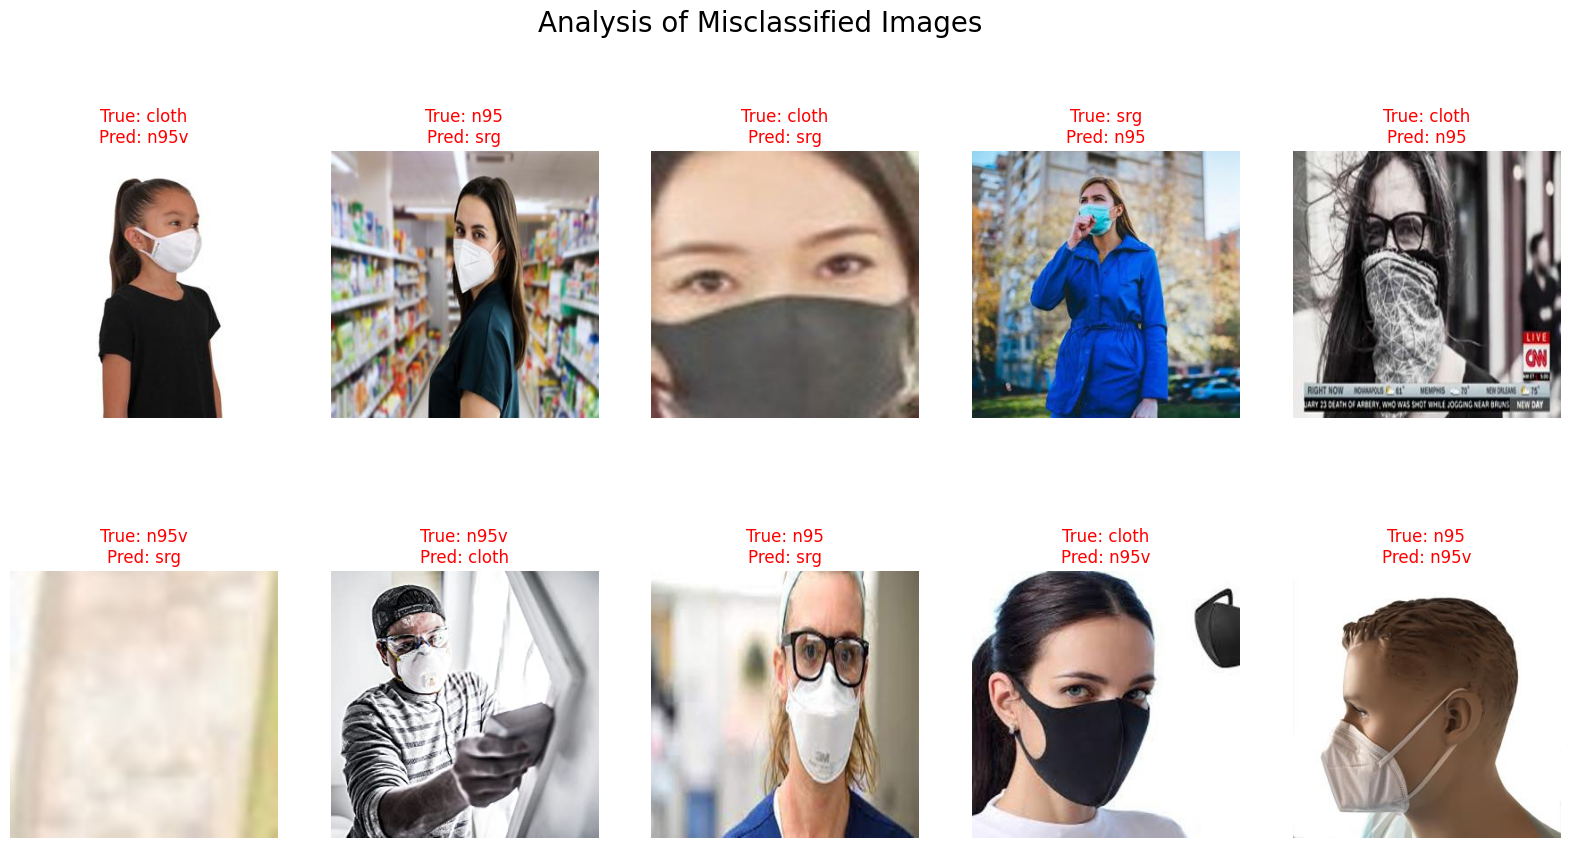

In [10]:
# ## 7. Performance Evaluation
if class_names and 'history' in locals():
    # 최종 테스트 데이터셋 성능 평가
    loss, accuracy = model.evaluate(test_generator)
    print(f'\nTest Accuracy: {accuracy*100:.2f}%')

    # ### 7.1. Accuracy and Loss Curves
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # ### 7.2. Confusion Matrix & Classification Report
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print('\nClassification Report')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # ### 7.3. Analysis of Misclassified Images
    misclassified_indices = np.where(y_pred != y_true)[0]
    if len(misclassified_indices) > 0:
        print(f"\nTotal misclassified images: {len(misclassified_indices)}\n")
        plt.figure(figsize=(20, 10))
        random_indices = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i + 1)
            img_path = test_generator.filepaths[idx]
            img = plt.imread(img_path)
            plt.imshow(img)
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='red')
            plt.axis('off')
        plt.suptitle('Analysis of Misclassified Images', fontsize=20)
        plt.show()
